Notebook to train a flow matching model on the 2D Muller Brown potential, and then compute transition paths with Onsager-Machlup (OM) optimization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

# Utility Functions
def slerp(v0, v1, t, DOT_THRESHOLD=0.9995):
    """
    Spherical linear interpolation between two vectors.
    Source: Andrej Karpathy's gist: https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355
    Args:
        v0 (torch.Tensor): the first vector
        v1 (torch.Tensor): the second vector
        t (torch.Tensor): scalar from 0 to 1 parameterizing the interpolation
    """
    v0 = v0.detach().cpu().numpy()
    v1 = v1.detach().cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1  # simple linear interpolation
    else:
        theta_0 = np.arccos(dot)  # angle between latent vectors
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1
    return v2

def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)


def get_numpy(tensor):
    return tensor.to("cpu").detach().numpy()


# Plotting
def visualize_mb_data(dataset, title="Muller Brown Training Data"):
    mb_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4096, shuffle=True)

    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing = "xy")
    z = calculator.U_split(x, y).cpu()

    fig, ax = plt.subplots()
    colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
    ax.set(xlabel="x-axis", ylabel="y-axis", title=title)
    plt.colorbar(colorbar)

    # also plot batch from dataloader
    for i, batch in tqdm(enumerate(mb_dataloader)):
        x, force = batch
        ax.scatter(x[:, 0], x[:, 1], color='red', s=0.1)
        
    ax.set_xlim([calculator.Lx, calculator.Hx])
    ax.set_ylim([calculator.Ly, calculator.Hy])

    plt.show()
    plt.close()


def plot_losses(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("NLL")

def plot_samples(samples: np.ndarray, title: str = "Muller Brown Samples") -> None:
    # plot a single plot with samples
    fig, ax = plt.subplots()
    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing = "xy")
    z = calculator.U_split(x, y).cpu()
    
        
    colorbar = ax.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(colorbar)
    ax.scatter(samples[:, 0], samples[:, 1], s = 0.3, color='red')

    ax.set_xlim([calculator.Lx, calculator.Hx])
    ax.set_ylim([calculator.Ly, calculator.Hy])
    plt.title(title)
    plt.show()
    plt.close()
    
def plot_flow_vector_field(
    model, 
    calculator, 
    t, 
    grid_width=20, 
    title="Flow Vector Field at Time t",
    arrow_scale=1.0, 
    arrow_width=0.002,
    mean=None,
    std=None,
    xmin=None, 
    xmax=None, 
    ymin=None, 
    ymax=None
):
    """
    Plots a vector field of the flow model at a specified time `t` in the original data space.

    Args:
        model (MBFlowMatchingModel): The trained flow matching model.
        calculator (MullerBrownPotential): Instance of the potential calculator to plot the energy landscape.
        t (int): The time step to condition the flow model.
        grid_width (int): Number of grid points along each axis for the vector field.
        title (str): Title for the plot.
        arrow_scale (float): Factor to scale the arrow length globally.
        arrow_width (float): Width of the arrows.
        mean (torch.Tensor): Mean of the dataset for normalization.
        std (torch.Tensor): Standard deviation of the dataset for normalization.
        xmin (float): Minimum x value for displaying arrows (default: calculator.Lx).
        xmax (float): Maximum x value for displaying arrows (default: calculator.Hx).
        ymin (float): Minimum y value for displaying arrows (default: calculator.Ly).
        ymax (float): Maximum y value for displaying arrows (default: calculator.Hy).
    """
    if mean is None or std is None:
        raise ValueError("Dataset mean and std must be provided to handle normalization.")

    # Use specified ranges or default to the calculator limits
    xmin = xmin if xmin is not None else calculator.Lx
    xmax = xmax if xmax is not None else calculator.Hx
    ymin = ymin if ymin is not None else calculator.Ly
    ymax = ymax if ymax is not None else calculator.Hy

    # Create a grid of evenly spaced points in the specified range
    x_values = torch.linspace(xmin, xmax, grid_width)
    y_values = torch.linspace(ymin, ymax, grid_width)
    x, y = torch.meshgrid(x_values, y_values, indexing="xy")
    grid_points_original = torch.stack([x.ravel(), y.ravel()], dim=-1).to(model.device)  # Shape: [grid_width**2, 2]

    # Normalize the grid points for evaluation
    grid_points_normalized = (grid_points_original - mean) / std

    # Conditioned time tensor
    t_tensor = torch.full((grid_points_normalized.shape[0], 1), t, device=model.device)
    
    # Evaluate the flow model in normalized space
    with torch.no_grad():
        flow_vectors_normalized = model.force_func(grid_points_normalized, t_tensor)

    # De-normalize the flow vectors to the original space
    flow_vectors_original = flow_vectors_normalized * std

    # Reshape grid and vectors for plotting
    u = flow_vectors_original[:, 0].reshape(grid_width, grid_width).cpu().numpy()
    v = flow_vectors_original[:, 1].reshape(grid_width, grid_width).cpu().numpy()
    x, y = x.cpu().numpy(), y.cpu().numpy()

    # Plot the energy landscape as background
    num_points = 100
    x_energy = torch.linspace(calculator.Lx, calculator.Hx, num_points)
    y_energy = torch.linspace(calculator.Ly, calculator.Hy, num_points)
    x_mesh, y_mesh = torch.meshgrid(x_energy, y_energy, indexing="xy")
    z_energy = calculator.U_split(x_mesh, y_mesh).cpu()

    fig, ax = plt.subplots()
    colorbar = ax.imshow(
        z_energy,
        extent=(x_energy.min(), x_energy.max(), y_energy.min(), y_energy.max()),
        vmin=calculator.U_min,
        vmax=calculator.U_max,
        origin='lower',
        cmap='viridis',
        aspect='auto'
    )
    plt.colorbar(colorbar, ax=ax)

    # Overlay vector field with scaling and width adjustment
    ax.quiver(
        x, y, u * arrow_scale, v * arrow_scale,  # Scale vectors
        color="red", scale=40, width=arrow_width, alpha=0.8
    )

    # Set plot limits and labels
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_title(title)
    
    plt.show()


def save_multi_scatter_2d(data: np.ndarray, steps: np.ndarray, title: str, paths: np.ndarray = None) -> None:
    num = torch.sqrt(torch.tensor(data.shape[0])).int().item()
    fig, axs = plt.subplots(num, num, figsize=(16, 13))
    num_points = 100
    x_values = torch.linspace(calculator.Lx, calculator.Hx , num_points)
    y_values = torch.linspace(calculator.Ly, calculator.Hy, num_points)

    x, y = torch.meshgrid(x_values, y_values, indexing="xy")
    z = calculator.U_split(x, y).cpu()
    def plot(axis, i, j):
        colorbar = axis.imshow(z, extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()), vmin=calculator.U_min, vmax=calculator.U_max, origin='lower', cmap='viridis', aspect='auto')
        plt.colorbar(colorbar)
        
        # plot initial and final paths (before and after OM optimization)
        if paths is not None:
            axis.plot(paths[i * num + j, 0, :, 0], paths[i * num + j, 0, :, 1], color='orange', label='Initial Path')
            axis.plot(paths[i * num + j, -1, :, 0], paths[i * num + j, -1, :, 1], color='purple', label='Final Path')
            
        # plot samples
        axis.scatter(data[i * num + j, :, 0], data[i * num + j, :, 1], s = 15, color='red')

        # plot path endpoints with x
        axis.scatter(data[i * num + j, 0, 0], data[i * num + j, 0, 1], s = 100, color='orange', marker='x')
        axis.scatter(data[i * 3 + j, -1, 0], data[i * 3 + j, -1, 1], s = 100, color='orange', marker='x')

        axis.set_xlim([calculator.Lx, calculator.Hx])
        axis.set_ylim([calculator.Ly, calculator.Hy])
        axis.set_title(f"{steps[i * num + j]}")
        axis.legend()

    if num == 1:
        plot(axs, 0, 0)
    else:
        for i in range(num):
            for j in range(num):
                plot(axs[i, j], i, j)
    fig.suptitle(title)


def linear_warmup_cosine_decay_lr_scheduler(optimizer, warmup_steps, total_steps, lr_min=0.0, lr_max=1.0):
    """
    Linear warmup with cosine decay 
    """
    def lr_lambda(current_step: int):
        if current_step < warmup_steps:
            # Linear warmup
            warmup_factor = current_step / float(max(1, warmup_steps))
            return lr_min + warmup_factor * (lr_max - lr_min)
        else:
            # Cosine decay
            progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return lr_min + 0.5 * (lr_max - lr_min) * (1 + torch.cos(torch.tensor(torch.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [3]:
from mb_dataset import MBDataset
from mb_calculator import MullerBrownPotential


calculator = MullerBrownPotential(device = "cpu")

train_dataset = MBDataset(preload_sim_dir="data/temp=700_timestep=5.0_friction=0.001/train_large", device = "cpu", calculator = calculator, load_forces = True)
test_dataset = MBDataset(preload_sim_dir="data/temp=700_timestep=5.0_friction=0.001/val_large", device = "cpu", calculator = calculator, load_forces = True)

/home/sanjeevr/miniforge3/envs/alphaflow/lib/python3.9/site-packages/ase/optimize/gpmin/gpmin.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import minimize


Loading simulations from directory: data/temp=700_timestep=5.0_friction=0.001/train_large


100%|██████████| 800/800 [05:39<00:00,  2.36it/s]


Loading simulations from directory: data/temp=700_timestep=5.0_friction=0.001/val_large


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


165it [00:19,  8.38it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f5e799567c0>>
Traceback (most recent call last):
  File "/home/sanjeevr/miniforge3/envs/alphaflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
196it [00:23,  8.31it/s]


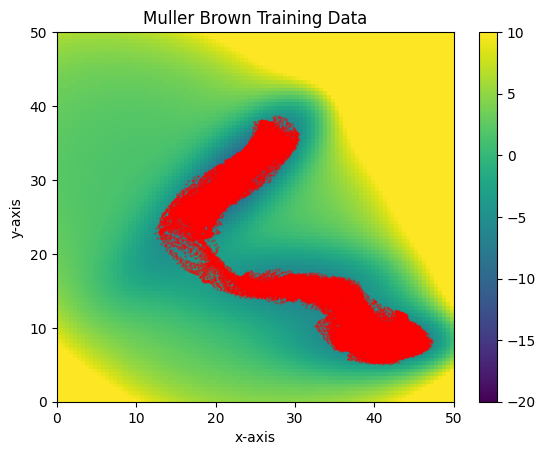

In [4]:
visualize_mb_data(train_dataset)

In [25]:
from mb_actions import S2Action, TruncatedAction, HutchinsonAction
from simpleMB import SimpleMB
import random
from ase import units
import math


from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper


potential = SimpleMB(device = "cuda",n_in=2)


# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
        
        self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
        self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

class MBFlowMatchingModel(torch.nn.Module):
    def __init__(self, mlp, num_steps, device):
        super(MBFlowMatchingModel, self).__init__()
        self.device = device
        self.num_steps = 20
        
        self.mlp = mlp
        self.input_dim = mlp.input_dim

        self.dt = 1.0 / num_steps
        self.path = AffineProbPath(scheduler=CondOTScheduler())

        self.mean = torch.tensor(np.load("data/mb_mean.npy")).to(device).to(torch.float32)
        self.std = torch.tensor(np.load("data/mb_std.npy")).to(device).to(torch.float32)

    
    def forward(self, x, t):
        return self.mlp(x, t)

    def scaling_factor(self, t):
        # print properties of self.path
        scaling_factor = - units.kB * 700 / self.path.scheduler(t).sigma_t
        return scaling_factor

    def force_func(self, x, t):
        noise_pred = self.forward(x, t)
        force = self.path.velocity_to_epsilon(noise_pred, x, t)
        force = self.scaling_factor(t) * force / self.std
        return force
    
    def laplacian_func(self, x, t):
        hessian_fn = torch.func.jacrev(self.force_func, argnums = 0)
        hessian = hessian_fn(x, t) # shape of [P x 2 x P x 2]
        # Extract the diagonal of the Hessian along the last two dimensions
        diag_hessian = torch.diagonal(hessian, dim1=1, dim2=-1)
        diag2_hessian = torch.diagonal(diag_hessian, dim1=0, dim2=1)
        # Sum over the last dimension (which corresponds to the second derivatives across different dimensions)
        laplace = diag2_hessian.sum(dim=0)
        return laplace
    
    def forward_flow(self, x, t, z=None):
        """
        Forward "flow" step:
        Given a data sample x and a time t in [0,1], produce x_t by linear interpolation with a Gaussian sample z.
        
        NOTE: we are actually interpolating between a gaussian shifted and scaled by
        data stats. We do the scaling here and assume z is sample
        This mirrors the forward diffusion in the flow matching context.
        """
        if z is None:
            z = torch.randn_like(x)  # Gaussian noise same shape as x
            
        # convert time to be in (0,1)
        t = t / self.num_steps
        x_t = (1 - t)*z + t*x
        return x_t

    @torch.no_grad 
    def sample_from_t(self, x_t, start_time=0):
        """
        Given samples x_t at time start_time, integrate forward to end_time using Euler's method.
        """
    
        solver = ODESolver(velocity_model=self.mlp)  # create an ODESolver class
        return solver.sample(time_grid=torch.linspace(0,1,10), x_init=x_t, method='midpoint', step_size=self.dt, return_intermediates=False) 

    @torch.no_grad
    def sample(self, num_samples):
        """
        Start from Gaussian noise at t=0 and integrate to t=1.
        """
        x_0 = torch.randn((num_samples, self.input_dim), device=self.device)
        return self.sample_from_t(x_0)
        
    @torch.no_grad
    def reconstruct(self, x, latent_time):
        """Forward diffusion of samples x to t = t and then sample from t to reconstruct x."""
        # Make sure x is normalized
        assert torch.all(torch.logical_and(x >= -5, x <= 5)), "x must be normalized"
        if isinstance(latent_time, torch.Tensor):
            latent_time = latent_time.item()
        if round(latent_time) != latent_time:
            latent_time = round(latent_time)
        
        with torch.no_grad():
            noised_x = self.forward_flow(x, latent_time, torch.randn_like(x).to(self.device))
            return self.sample_from_t(noised_x, latent_time)
    
    def interpolation(self, x1, x2, path_length, latent_time, num_paths = 10, interpolation_fn = torch.lerp):
        """"
        Encode the two points into latent space, linearly or spherically interpolate, and decode.
        Note: Expects x1 and x2 to be normalized.
        """
        # Make sure x1 and x2 are normalized
        assert torch.all(torch.logical_and(x1 >= -5, x1 <= 5)), "x1 must be normalized"
        assert torch.all(torch.logical_and(x2 >= -5, x2 <= 5)), "x2 must be normalized"
        if isinstance(latent_time, torch.Tensor):
            latent_time = latent_time.item()
        
        if round(latent_time) != latent_time:
            latent_time = round(latent_time)

        x1 = x1.repeat(num_paths, 1)
        x2 = x2.repeat(num_paths, 1)
        original_x1 = x1.clone()
        original_x2 = x2.clone()

        with torch.no_grad():
            noise_1 = torch.randn_like(x1).to(self.device)
            noise_2 = torch.randn_like(x2).to(self.device)
            noised_x1 = self.forward_flow(x1, latent_time, noise_1)
            noised_x2 = self.forward_flow(x2, latent_time, noise_2)

        # linear interpolation of noised_x1 and noised_x2
        
        noised_xs = torch.stack([interpolation_fn(noised_x1.cpu(), noised_x2.cpu(), alpha) for alpha in torch.linspace(0, 1, path_length)])
        noised_xs = noised_xs.permute((1, 0, 2)).to(self.device)
    
        # decode
        xs = self.sample_from_t(noised_xs.reshape(-1, 2), latent_time)

        xs = xs.reshape(num_paths, path_length, 2)
        xs = xs.clone().detach()

        # reset the endpoints
        xs[:, 0], xs[:, -1] = original_x1, original_x2
        
        return xs
        
    def om_interpolation(self, x1, x2, path_length, latent_time, num_paths = 10, action_cls = S2Action, initial_guess_fn = torch.lerp, om_steps = 100, lr = 2e-1, anneal = False, temperature = 1.0, D=0.1, dt=0.01, gamma=0.01):
        """"
        Encode the two points into latent space, linearly interpolate, and decode
        Note: Expects x1 and x2 to be normalized.
        """
        # Make sure x1 and x2 are normalized
        assert torch.all(torch.logical_and(x1 >= -5, x1 <= 5)), "x1 must be normalized"
        assert torch.all(torch.logical_and(x2 >= -5, x2 <= 5)), "x2 must be normalized"

        if anneal:
            om_steps = self.num_steps # to make sure we anneal from T to 0

        x1 = x1.repeat(num_paths, 1)
        x2 = x2.repeat(num_paths, 1)

        original_x1 = x1.clone()
        original_x2 = x2.clone()
        # with torch.no_grad():
            # noise_1 = torch.randn_like(x1).to(self.device)
            # noise_2 = torch.randn_like(x2).to(self.device)
            
            # noised_x1 = self.forward_flow(x1, latent_time, noise_1)
            # noised_x2 = self.forward_flow(x2, latent_time, noise_2)
            
        noised_x1 = original_x1
        noised_x2 = original_x2
            
        # linear interpolation of noised_x1 and noised_x2
        noised_xs = torch.stack([initial_guess_fn(noised_x1.cpu(), noised_x2.cpu(), alpha) for alpha in torch.linspace(0, 1, path_length)])
        noised_xs = noised_xs.permute((1, 0, 2)).to(self.device)  # shape of [num_paths x path_length x 2]
        optimizer = torch.optim.Adam([noised_xs], lr = lr)

        pbar = tqdm(range(om_steps))
        paths = []
        actions = []

        with torch.enable_grad():
            noised_xs.requires_grad = True
            # Optimization of path using OM action
            for i in pbar:
                if anneal:
                    diff_time = self.num_steps - i - 1 # anneal the time from T to 0
                else:
                    diff_time = latent_time
            
                
                force_func = lambda x: self.force_func(x, torch.tensor([diff_time], device="cuda"))
                laplace = lambda x: self.laplacian_func(x, torch.tensor([diff_time], device="cuda"))
                if action_cls == HutchinsonAction:
                    action_func = action_cls(
                        force_func=force_func,
                        laplace_func=laplace,
                        dt=dt,
                        gamma=gamma,
                        D=D,
                        diffusion_model=True,
                    )
                else:
                    action_func = action_cls(
                        force_func=force_func,
                        laplace_func=laplace,
                        dt=dt,
                        gamma=gamma,
                        D=D,
                    )
                
            
                action = torch.vmap(action_func, randomness="different")(noised_xs).mean()
                actions.append(action.item())

                pred_force = force_func(noised_xs.reshape(-1, 2))
                true_force = potential.force_func(noised_xs.reshape(-1, 2))[1]
            

                optimizer.zero_grad()
                grads, = torch.autograd.grad(action, noised_xs)
            
                with torch.no_grad():
                    
                    # Set endpoint grads to 0
                    grads[:, 0], grads[:, -1] = torch.zeros(2).to(self.device), torch.zeros(2).to(self.device)
                    
                    noised_xs.grad = grads
                    optimizer.step()
    

                pbar.set_description(f"OM Action: {action.item()}")
                
                if i % int(om_steps / 10) == 0:
                    with torch.no_grad():
                        decoded_path = noised_xs.reshape(num_paths, path_length, 2)
                        paths.append(decoded_path.detach())

        # decode along optimized path
        with torch.no_grad():
            xs = noised_xs
            xs = xs.reshape(num_paths, path_length, 2)
            xs = xs.clone().detach()

            # reset the endpoints
            xs[:, 0], xs[:, -1] = original_x1, original_x2

            return xs, paths, actions

In [13]:
import wandb

def train_mb_flowmatching(train_dataset, test_dataset, model, n_epochs, device, lr, batch_size, force_supervision_level = None):
    """

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    """

    PI = torch.tensor([np.pi]).to(device)
    optimizer = optim.Adam(model.mlp.parameters(), lr = lr)

    # instantiate an affine path object
    path = AffineProbPath(scheduler=CondOTScheduler())
    #normalize training data
    tensor_data = train_dataset.all_pos.reshape(-1,3)[:,:2]
    tensor_dataset = torch.from_numpy(tensor_data).float()
    tensor_dataset = TensorDataset(tensor_dataset) 
    train_dataloader = DataLoader(tensor_dataset, batch_size=batch_size)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
    std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
    
    train_losses = []
    test_losses = []
    for e in range(n_epochs):
        model.train()
        print(f"Epoch {e+1}")
        with torch.enable_grad():
        
            for x in tqdm(train_dataloader):
                optimizer.zero_grad()
                x_1 = x[0].to(device)
                
                x_1 = (x_1 - mean) / std

                x_0 = torch.randn_like(x_1).to(device)

                # sample time (user's responsibility)
                t = torch.rand(x_1.shape[0]).to(device) 
                

                # sample probability path
                path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
                
                u_t = path_sample.dx_t 

                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - u_t, 2).mean() 

                # optimizer step
                loss.backward() # backward
                optimizer.step() # update
                
                train_losses.append(loss.unsqueeze(-1))
                

        model.eval()
        tls = []
        with torch.no_grad():
            for x, force in test_dataloader:
                
                x = x.to(device)
                force = force.to(device)
                x = (x - mean) / std
                
                #sample diffusion timestep (uniform between 0 and num_steps exclusive)
                t = torch.randint(0, model.num_steps, (x.shape[0],1)).to(x.device)

                # sample noise and diffuse
                noise = torch.randn_like(x)
                noised_x = model.forward_flow(x, t, noise)
                
                #forward pass
                pred_noise = model(noised_x, t).to(torch.float32)
                #compute loss and optimize
                loss = F.mse_loss(pred_noise, noise)
                tls.append(loss.unsqueeze(-1))

                # for logging force loss
                t = torch.ones_like(t)
                pred_force = model.force_func(x, t)
                log_force_mse = F.mse_loss(pred_force, force)
                log_force_cosine = F.cosine_similarity(pred_force, force).mean()

            test_loss = torch.cat(tls).sum(0) / len(tls)
            test_losses.append(test_loss.unsqueeze(-1))
            if not DISABLE_WANDB_LOGGING: 
                wandb.log({"test_loss": test_loss, "test_force_mse": log_force_mse, "test_force_cosine": log_force_cosine})
            
    return get_numpy(torch.cat(train_losses)), get_numpy(torch.cat(test_losses))

/tmp/ipykernel_920493/1687931762.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/1687931762.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_920493/1687931762.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/1687931762.py:77: UserWarning: To copy const

Epoch 1


  0%|          | 0/196 [00:00<?, ?it/s]

100%|██████████| 196/196 [00:04<00:00, 48.09it/s]


Epoch 2


100%|██████████| 196/196 [00:04<00:00, 48.91it/s]


Epoch 3


100%|██████████| 196/196 [00:04<00:00, 47.89it/s]


Epoch 4


100%|██████████| 196/196 [00:03<00:00, 49.50it/s]


Epoch 5


100%|██████████| 196/196 [00:03<00:00, 49.56it/s]


Epoch 6


100%|██████████| 196/196 [00:03<00:00, 49.19it/s]


Epoch 7


100%|██████████| 196/196 [00:03<00:00, 49.10it/s]


Epoch 8


100%|██████████| 196/196 [00:03<00:00, 50.56it/s]


Epoch 9


100%|██████████| 196/196 [00:04<00:00, 48.05it/s]


Epoch 10


100%|██████████| 196/196 [00:03<00:00, 49.14it/s]


Epoch 11


100%|██████████| 196/196 [00:03<00:00, 50.48it/s]


Epoch 12


100%|██████████| 196/196 [00:04<00:00, 48.62it/s]


Epoch 13


100%|██████████| 196/196 [00:04<00:00, 47.93it/s]


Epoch 14


100%|██████████| 196/196 [00:04<00:00, 46.89it/s]


Epoch 15


100%|██████████| 196/196 [00:04<00:00, 46.31it/s]


Epoch 16


100%|██████████| 196/196 [00:04<00:00, 46.93it/s]


Epoch 17


100%|██████████| 196/196 [00:04<00:00, 48.93it/s]


Epoch 18


100%|██████████| 196/196 [00:04<00:00, 47.63it/s]


Epoch 19


100%|██████████| 196/196 [00:04<00:00, 46.81it/s]


Epoch 20


100%|██████████| 196/196 [00:04<00:00, 46.04it/s]


Epoch 21


100%|██████████| 196/196 [00:04<00:00, 46.58it/s]


Epoch 22


100%|██████████| 196/196 [00:04<00:00, 46.06it/s]


Epoch 23


100%|██████████| 196/196 [00:04<00:00, 46.44it/s]


Epoch 24


100%|██████████| 196/196 [00:04<00:00, 46.57it/s]


Epoch 25


100%|██████████| 196/196 [00:04<00:00, 47.84it/s]


Epoch 26


100%|██████████| 196/196 [00:04<00:00, 46.38it/s]


Epoch 27


100%|██████████| 196/196 [00:04<00:00, 46.78it/s]


Epoch 28


100%|██████████| 196/196 [00:04<00:00, 46.44it/s]


Epoch 29


100%|██████████| 196/196 [00:04<00:00, 47.19it/s]


Epoch 30


100%|██████████| 196/196 [00:04<00:00, 46.31it/s]


Epoch 31


100%|██████████| 196/196 [00:04<00:00, 46.56it/s]


Epoch 32


100%|██████████| 196/196 [00:04<00:00, 46.41it/s]


Epoch 33


100%|██████████| 196/196 [00:04<00:00, 46.34it/s]


Epoch 34


100%|██████████| 196/196 [00:04<00:00, 47.75it/s]


Epoch 35


100%|██████████| 196/196 [00:04<00:00, 46.91it/s]


Epoch 36


100%|██████████| 196/196 [00:04<00:00, 46.17it/s]


Epoch 37


100%|██████████| 196/196 [00:04<00:00, 45.21it/s]


Epoch 38


100%|██████████| 196/196 [00:04<00:00, 44.45it/s]


Epoch 39


100%|██████████| 196/196 [00:04<00:00, 45.23it/s]


Epoch 40


100%|██████████| 196/196 [00:04<00:00, 45.51it/s]


Epoch 41


100%|██████████| 196/196 [00:04<00:00, 45.08it/s]


Epoch 42


100%|██████████| 196/196 [00:04<00:00, 46.24it/s]


Epoch 43


100%|██████████| 196/196 [00:04<00:00, 45.97it/s]


Epoch 44


100%|██████████| 196/196 [00:04<00:00, 45.04it/s]


Epoch 45


100%|██████████| 196/196 [00:04<00:00, 45.30it/s]


Epoch 46


100%|██████████| 196/196 [00:04<00:00, 44.95it/s]


Epoch 47


100%|██████████| 196/196 [00:04<00:00, 45.31it/s]


Epoch 48


100%|██████████| 196/196 [00:04<00:00, 45.26it/s]


Epoch 49


100%|██████████| 196/196 [00:04<00:00, 46.20it/s]


Epoch 50


100%|██████████| 196/196 [00:04<00:00, 45.91it/s]


Epoch 51


100%|██████████| 196/196 [00:04<00:00, 48.06it/s]


Epoch 52


100%|██████████| 196/196 [00:04<00:00, 46.03it/s]


Epoch 53


100%|██████████| 196/196 [00:04<00:00, 46.10it/s]


Epoch 54


100%|██████████| 196/196 [00:04<00:00, 47.08it/s]


Epoch 55


100%|██████████| 196/196 [00:04<00:00, 45.33it/s]


Epoch 56


100%|██████████| 196/196 [00:04<00:00, 44.77it/s]


Epoch 57


100%|██████████| 196/196 [00:04<00:00, 46.06it/s]


Epoch 58


100%|██████████| 196/196 [00:04<00:00, 47.09it/s]


Epoch 59


100%|██████████| 196/196 [00:03<00:00, 49.14it/s]


Epoch 60


100%|██████████| 196/196 [00:04<00:00, 44.26it/s]


Epoch 61


100%|██████████| 196/196 [00:04<00:00, 44.22it/s]


Epoch 62


100%|██████████| 196/196 [00:04<00:00, 46.22it/s]


Epoch 63


100%|██████████| 196/196 [00:04<00:00, 46.37it/s]


Epoch 64


100%|██████████| 196/196 [00:04<00:00, 45.73it/s]


Epoch 65


100%|██████████| 196/196 [00:04<00:00, 45.65it/s]


Epoch 66


100%|██████████| 196/196 [00:04<00:00, 45.62it/s]


Epoch 67


100%|██████████| 196/196 [00:04<00:00, 47.45it/s]


Epoch 68


100%|██████████| 196/196 [00:04<00:00, 47.38it/s]


Epoch 69


100%|██████████| 196/196 [00:04<00:00, 47.17it/s]


Epoch 70


100%|██████████| 196/196 [00:04<00:00, 45.75it/s]


Epoch 71


100%|██████████| 196/196 [00:04<00:00, 45.69it/s]


Epoch 72


100%|██████████| 196/196 [00:04<00:00, 46.68it/s]


Epoch 73


100%|██████████| 196/196 [00:04<00:00, 47.61it/s]


Epoch 74


100%|██████████| 196/196 [00:04<00:00, 46.96it/s]


Epoch 75


100%|██████████| 196/196 [00:04<00:00, 45.10it/s]


Epoch 76


100%|██████████| 196/196 [00:04<00:00, 44.74it/s]


Epoch 77


100%|██████████| 196/196 [00:04<00:00, 46.93it/s]


Epoch 78


100%|██████████| 196/196 [00:04<00:00, 46.86it/s]


Epoch 79


100%|██████████| 196/196 [00:04<00:00, 46.78it/s]


Epoch 80


100%|██████████| 196/196 [00:04<00:00, 43.79it/s]


Epoch 81


100%|██████████| 196/196 [00:04<00:00, 43.71it/s]


Epoch 82


100%|██████████| 196/196 [00:04<00:00, 45.38it/s]


Epoch 83


100%|██████████| 196/196 [00:04<00:00, 45.00it/s]


Epoch 84


100%|██████████| 196/196 [00:04<00:00, 45.43it/s]


Epoch 85


100%|██████████| 196/196 [00:04<00:00, 43.50it/s]


Epoch 86


100%|██████████| 196/196 [00:04<00:00, 44.19it/s]


Epoch 87


100%|██████████| 196/196 [00:04<00:00, 45.13it/s]


Epoch 88


100%|██████████| 196/196 [00:04<00:00, 45.59it/s]


Epoch 89


100%|██████████| 196/196 [00:04<00:00, 45.76it/s]


Epoch 90


100%|██████████| 196/196 [00:04<00:00, 44.68it/s]


Epoch 91


100%|██████████| 196/196 [00:04<00:00, 44.33it/s]


Epoch 92


100%|██████████| 196/196 [00:04<00:00, 44.90it/s]


Epoch 93


100%|██████████| 196/196 [00:04<00:00, 43.24it/s]


Epoch 94


100%|██████████| 196/196 [00:04<00:00, 44.81it/s]


Epoch 95


100%|██████████| 196/196 [00:04<00:00, 43.50it/s]


Epoch 96


100%|██████████| 196/196 [00:04<00:00, 44.03it/s]


Epoch 97


100%|██████████| 196/196 [00:04<00:00, 43.23it/s]


Epoch 98


100%|██████████| 196/196 [00:04<00:00, 44.93it/s]


Epoch 99


100%|██████████| 196/196 [00:04<00:00, 44.17it/s]


Epoch 100


100%|██████████| 196/196 [00:04<00:00, 44.99it/s]


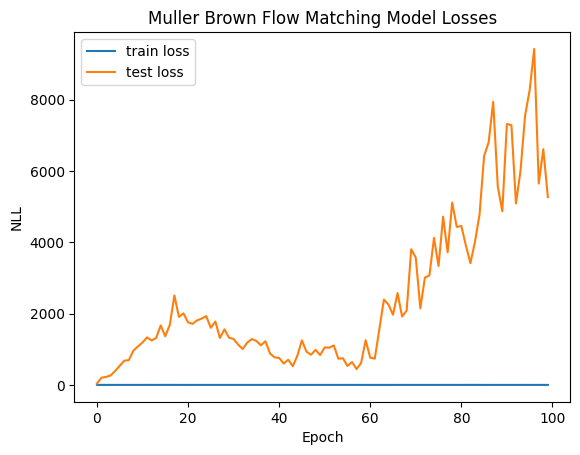

In [14]:

# Train model - can skip this if you want to just load the provided checkpoint

# Training config
config = {
    "n_epochs": 100,
    "batch_size": 4096,
    "num_steps": 20,
    "lr": 0.0012,
    "force_supervision_level": None,
    "mlp_hidden_dim": 512,
    "conservative": False
}

# no wandb logging for now
DISABLE_WANDB_LOGGING = True

device = torch.device(torch.cuda.current_device())
mlp = MLP(input_dim=2, time_dim=1, hidden_dim=config["mlp_hidden_dim"]).to(device) 
model = MBFlowMatchingModel(mlp, num_steps = config["num_steps"], device = device).to(device).to(torch.float32)

if not DISABLE_WANDB_LOGGING:   
    wandb.login()
    wandb.init(project="mb-flowmatching-model", config=config, name="mb_flowmatching")
    wandb.watch(mlp)

# Train model
train_losses, test_losses = train_mb_flowmatching(train_dataset, test_dataset, model, n_epochs = config["n_epochs"], \
                                                lr = config["lr"], batch_size = config["batch_size"], device = device, \
                                                force_supervision_level = config["force_supervision_level"])
plot_losses(train_losses, test_losses, title="Muller Brown Flow Matching Model Losses")

# save model checkpoint (locally and on wandb)
torch.save(mlp.state_dict(), "results/checkpoints/mb_flowmatching_model2.pt")
if not DISABLE_WANDB_LOGGING:
    wandb.save('mb_flowmatching_model.pt')
    wandb.finish()

In [15]:
mean = torch.tensor(np.load("data/mb_mean.npy")).to(device).to(torch.float32)
std = torch.tensor(np.load("data/mb_std.npy")).to(device).to(torch.float32)

In [16]:
del mlp, model

/tmp/ipykernel_920493/1687931762.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/1687931762.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_920493/950115170.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

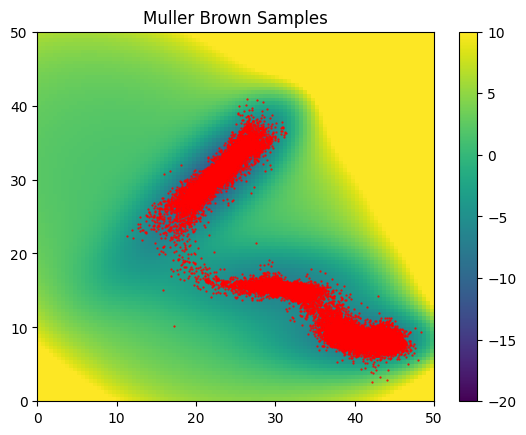

In [18]:
# Unconditional samples from the model
device = torch.device(torch.cuda.current_device())
mlp = MLP(input_dim=2, time_dim=1, hidden_dim=config["mlp_hidden_dim"]).to(device) 
mlp.load_state_dict(torch.load("results/checkpoints/mb_flowmatching_model.pt"))
model = MBFlowMatchingModel(mlp, num_steps = config["num_steps"], device = device).to(device).to(torch.float32)
all_samples = model.sample(100000)
mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
all_samples = all_samples*std + mean
all_samples = get_numpy(all_samples)
np.save("results/mb_fm_samples.npy", all_samples)
# save samples

plot_samples(all_samples, title="Muller Brown Samples") 

In [50]:
del mlp, model

/tmp/ipykernel_920493/1687931762.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/1687931762.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_920493/354493939.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

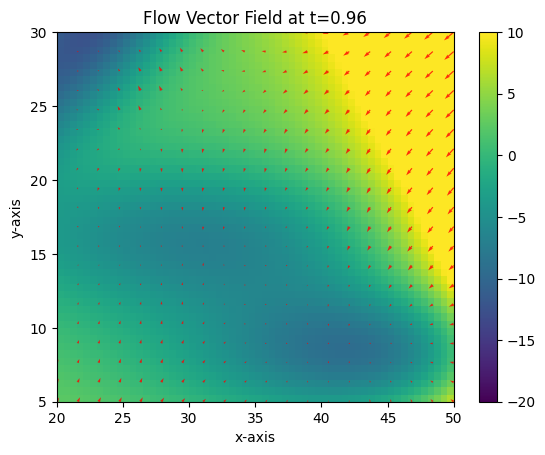

In [19]:
# Plot flow vector field
mlp = MLP(input_dim=2, time_dim=1, hidden_dim=config["mlp_hidden_dim"]).to(device) 
mlp.load_state_dict(torch.load("results/checkpoints/mb_flowmatching_model.pt"))
model = MBFlowMatchingModel(mlp, num_steps = config["num_steps"], device = device).to(device).to(torch.float32)
mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
std = torch.tensor(train_dataset.std).to(device).to(torch.float32)

path = AffineProbPath(scheduler=CondOTScheduler())
score_conversion = lambda x, t: path.velocity_to_epsilon(model(x, t), x, t)

# Custom limits for arrows
xmin, xmax = 20,50
ymin, ymax = 5, 30
# Plot vector field
t = 0.96# Specify the time step to condition on
plot_flow_vector_field(
    model, 
    calculator, 
    t, 
    grid_width=20, 
    title=f"Flow Vector Field at t={t}",
    arrow_scale=0.1, 
    arrow_width=0.003,
    mean=mean,
    std=std,
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax
)

In [20]:
# Define common args for interpolation experiments
latent_times = torch.linspace(0, 1, 9).to(torch.long).to(device)

# start and end points for interpolation - different from basins to ensure we're not just i.i.d sampling
x1 = torch.Tensor([[23, 30]]).to(device)
x2 = torch.Tensor([[40, 9]]).to(device)

# Normalize the points
x1 = (x1 - mean) / std
x2 = (x2 - mean) / std


# Flow matching OM interpolation example

/tmp/ipykernel_920493/2703638921.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/2703638921.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_920493/336101083.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

OM Action: 20.630451202392578: 100%|██████████| 1000/1000 [00:14<00:00, 68.15it/s]


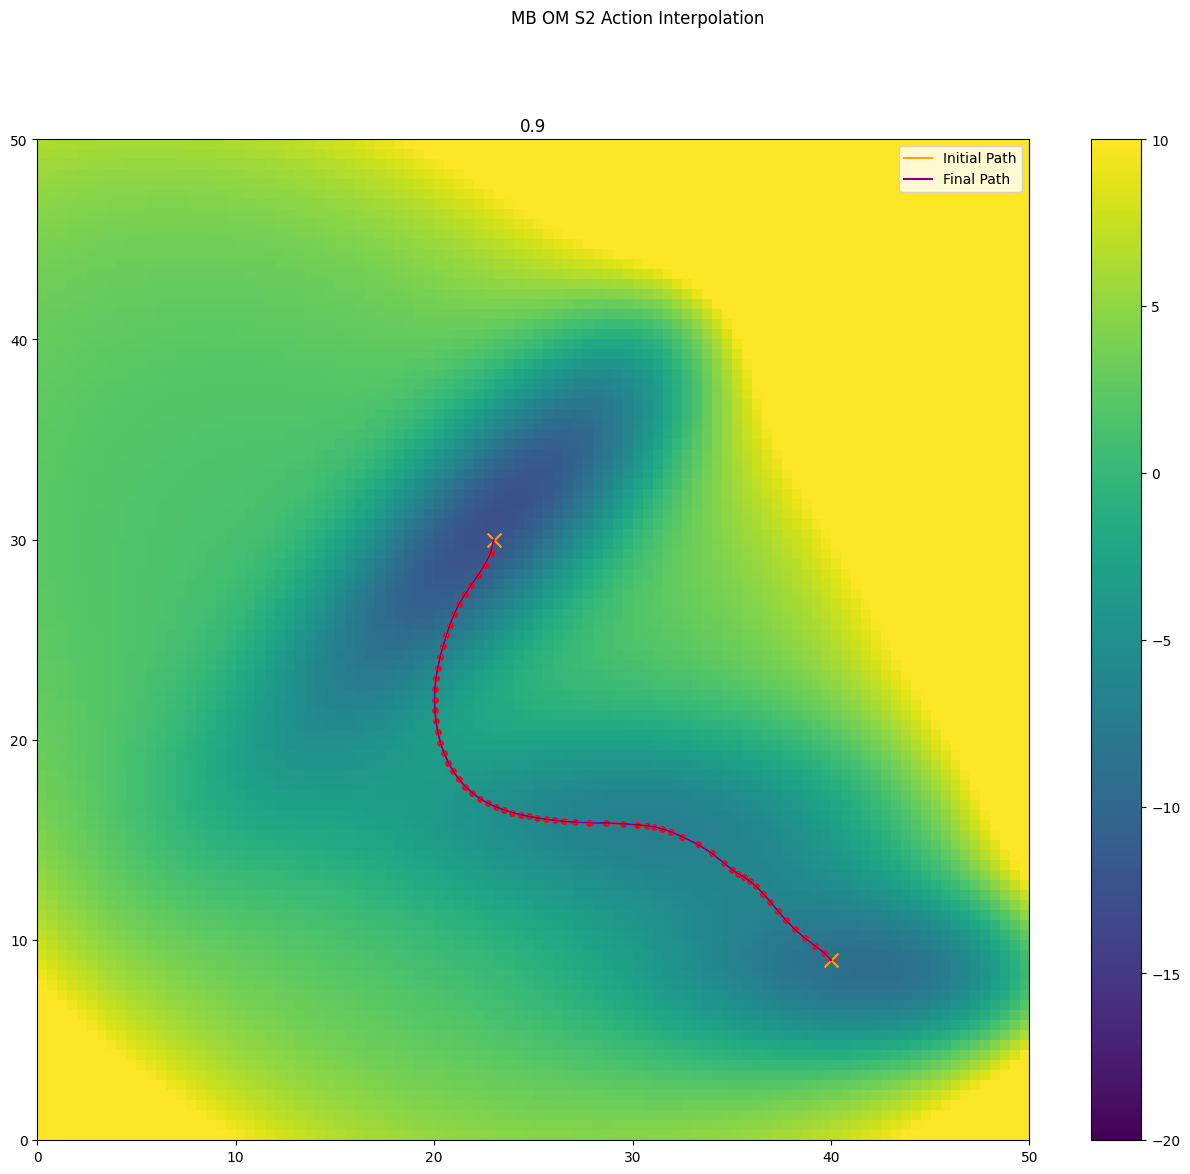

In [27]:
# Interpolation with S2 Action
latent_times = [0.9]
mlp = MLP(input_dim=2, time_dim=1, hidden_dim=config["mlp_hidden_dim"]).to(device) 
mlp.load_state_dict(torch.load("results/checkpoints/mb_flowmatching_model.pt"))
model = MBFlowMatchingModel(mlp, num_steps = 20, device = device).to(device).to(torch.float32)
out = [model.om_interpolation(x1, x2, path_length=64, num_paths = 1, latent_time=time, action_cls=S2Action, om_steps = 1000, lr = 2e-2, dt=0.01, D=0) for time in latent_times] 

samples, paths, actions = zip(*out)
samples = torch.stack(samples)
samples = samples*std + mean
samples = get_numpy(samples.reshape(len(latent_times), -1, 2))

paths = torch.stack([torch.stack(p) for p in paths])
paths = paths*std + mean

paths = get_numpy(paths.mean(dim = 2)) # average over paths

save_multi_scatter_2d(samples, latent_times, title = "MB OM S2 Action Interpolation", paths = paths)

/tmp/ipykernel_920493/2703638921.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/2703638921.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_920493/2739230155.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

OM Action: 1299.769287109375: 100%|██████████| 1000/1000 [00:12<00:00, 78.27it/s]


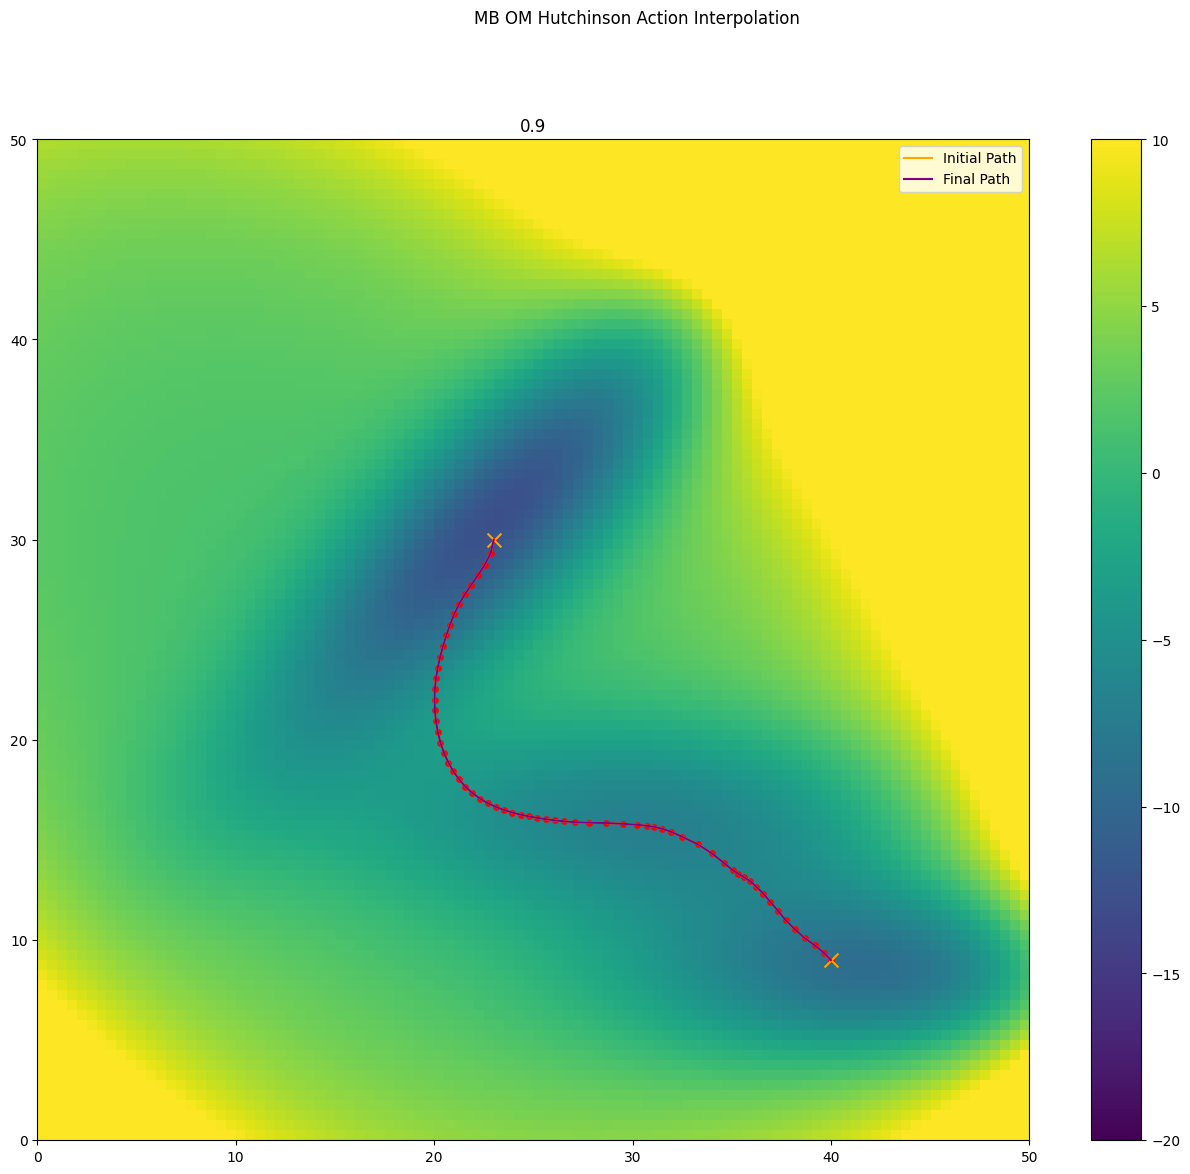

In [29]:
# Interpolation with Hutchinson Action
latent_times = [0.9]
mlp = MLP(input_dim=2, time_dim=1, hidden_dim=config["mlp_hidden_dim"]).to(device) 
mlp.load_state_dict(torch.load("results/checkpoints/mb_flowmatching_model.pt"))
model = MBFlowMatchingModel(mlp, num_steps = 20, device = device).to(device).to(torch.float32)
out = [model.om_interpolation(x1, x2, path_length=64, num_paths = 1, latent_time=time, action_cls=HutchinsonAction, om_steps = 1000, lr = 2e-2, dt=0.01, D=0) for time in latent_times] 

samples, paths, actions = zip(*out)
samples = torch.stack(samples)
samples = samples*std + mean
samples = get_numpy(samples.reshape(len(latent_times), -1, 2))

paths = torch.stack([torch.stack(p) for p in paths])
paths = paths*std + mean

paths = get_numpy(paths.mean(dim = 2)) # average over paths

save_multi_scatter_2d(samples, latent_times, title = "MB OM Hutchinson Action Interpolation", paths = paths)

/tmp/ipykernel_920493/2703638921.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(train_dataset.mean).to(device).to(torch.float32)
/tmp/ipykernel_920493/2703638921.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(train_dataset.std).to(device).to(torch.float32)
/tmp/ipykernel_920493/2502854797.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

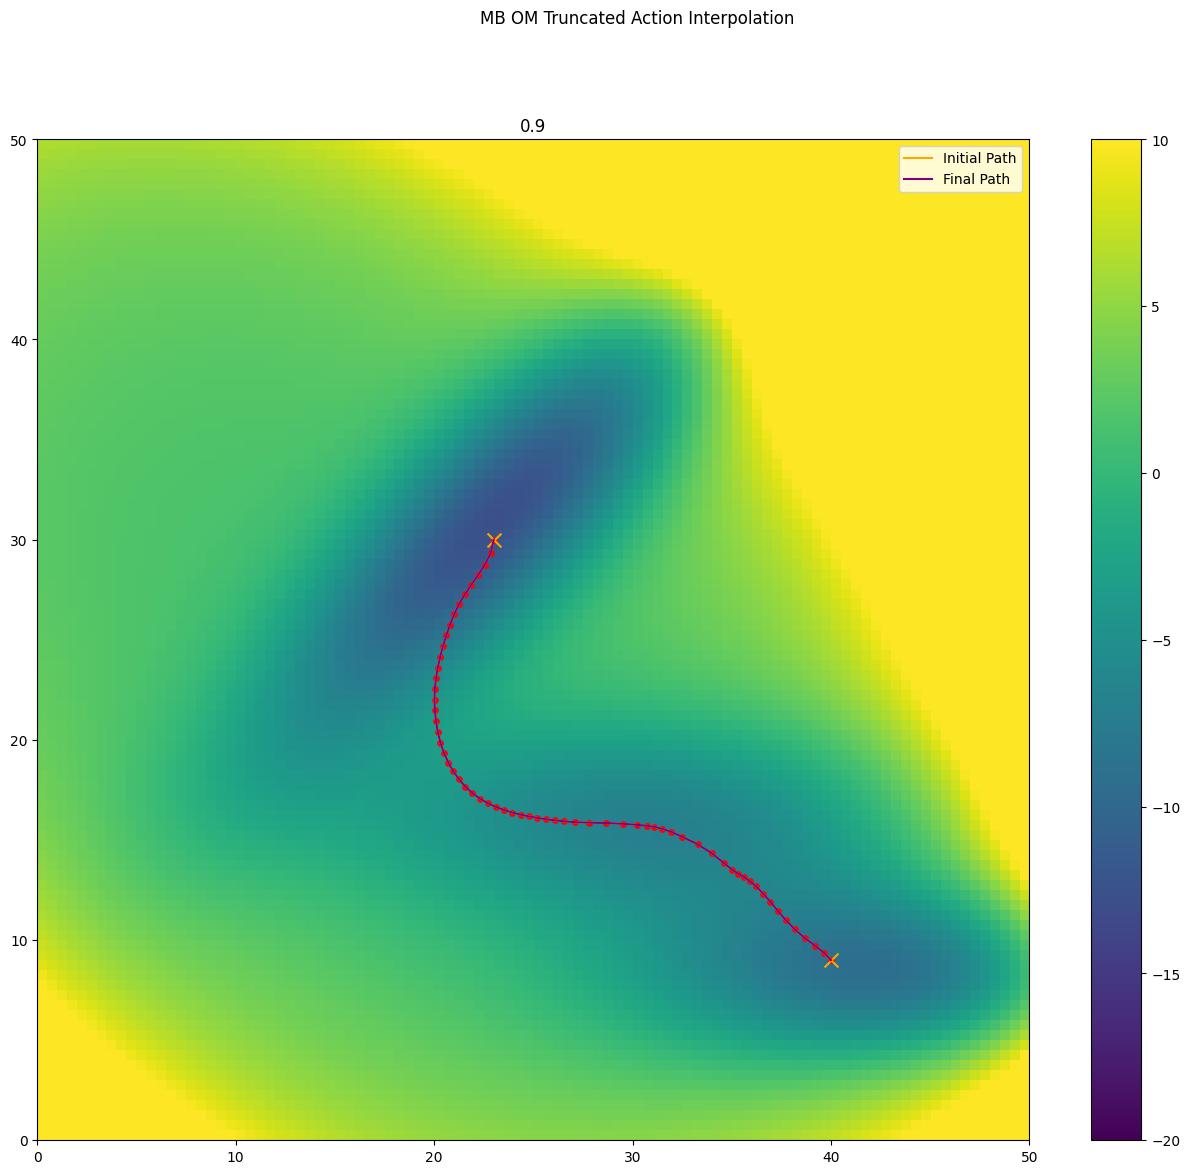

In [30]:
# Interpolation with Truncated Action
latent_times = [0.9]
mlp = MLP(input_dim=2, time_dim=1, hidden_dim=config["mlp_hidden_dim"]).to(device) 
mlp.load_state_dict(torch.load("results/checkpoints/mb_flowmatching_model.pt"))
model = MBFlowMatchingModel(mlp, num_steps = 20, device = device).to(device).to(torch.float32)
out = [model.om_interpolation(x1, x2, path_length=64, num_paths = 1, latent_time=time, action_cls=TruncatedAction, om_steps = 1000, lr = 2e-2, dt=0.01, D=0) for time in latent_times] 

samples, paths, actions = zip(*out)
samples = torch.stack(samples)
samples = samples*std + mean
samples = get_numpy(samples.reshape(len(latent_times), -1, 2))

paths = torch.stack([torch.stack(p) for p in paths])
paths = paths*std + mean

paths = get_numpy(paths.mean(dim = 2)) # average over paths

save_multi_scatter_2d(samples, latent_times, title = "MB OM Truncated Action Interpolation", paths = paths)